In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import torch

In [3]:

from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.utils import from_networkx
import networkx as nx


d:\anaconda\Lib\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


In [4]:
from transformers import BertModel, BertTokenizer

In [5]:
from torch.utils.data import Dataset
from torch_geometric.data import Batch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import softmax
from torch.utils.data import DataLoader
import swifter
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import GCNConv
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error


In [6]:
import torch_geometric
print(torch_geometric.__version__)
from torch_geometric.nn import global_mean_pool  # Test import


2.6.1


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from rdkit.Chem import PeriodicTable

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [9]:
def convert_compound_to_graph(compound_smiles):
    """
    Convert compound SMILES string to a graph representation.
    
    :param compound_smiles: SMILES string of a compound.
    :return: Graph representation (PyTorch Geometric Data object).
    """
    mol = Chem.MolFromSmiles(compound_smiles)
    if mol is None:
        return None
    
    atom_features = []
    for atom in mol.GetAtoms():
        atom_feature = [
            atom.GetAtomicNum(), 
            atom.GetTotalNumHs(),  
            atom.GetFormalCharge(), 
            atom.GetIsAromatic(),
            atom.GetHybridization(),
        ]
        atom_features.append(atom_feature)

    edge_index = []
    edge_types = []
    for bond in mol.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = bond.GetBondTypeAsDouble()
        
        edge_index.append([start_atom, end_atom])
        edge_index.append([end_atom, start_atom])
        
        edge_types.append([bond_type])
        edge_types.append([bond_type])

    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_types, dtype=torch.float)
    
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    return graph_data

In [10]:
def atomic_number_to_symbol(atomic_num):
    return PeriodicTable.GetElementSymbol(Chem.GetPeriodicTable(), atomic_num)

def visualize_graph_with_bonds(graph_data, compound_smiles):

    G = nx.Graph()
    edge_index = graph_data.edge_index.t().numpy()
    bond_types = graph_data.edge_attr.numpy()

    # Add nodes and edges with bond types to the graph
    for i, (start, end) in enumerate(edge_index):
        G.add_edge(start, end, bond_type=bond_types[i])

    pos = nx.spring_layout(G)  # Layout for better visualization

    # Convert atomic numbers to element symbols for node labels
    labels = {i: atomic_number_to_symbol(int(graph_data.x[i, 0].item())) 
              for i in range(graph_data.num_nodes)}

    # Convert bond type to a meaningful label
    def get_bond_label(bond_type):
        if bond_type == 1.5:
            return "Aromatic"
        else:
            return str(bond_type)

    # Extract bond labels with meaningful names
    edge_labels = {
        (start, end): get_bond_label(bond_type[0]) 
        for (start, end, bond_type) in G.edges(data='bond_type')
    }

    # Plot the graph with meaningful bond labels
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_color='skyblue', node_size=500, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title(f"Graph Representation of {compound_smiles}")
    plt.show()



In [11]:
from rdkit.Chem import Draw

In [12]:

# Save to a new file after populating graphs and embeddings
#kiba_data.to_pickle('processed_kiba_data.pkl')  # Save as a pickle file

# Load it later
kiba_data = pd.read_pickle('kiba_with_molecular_features.pkl')


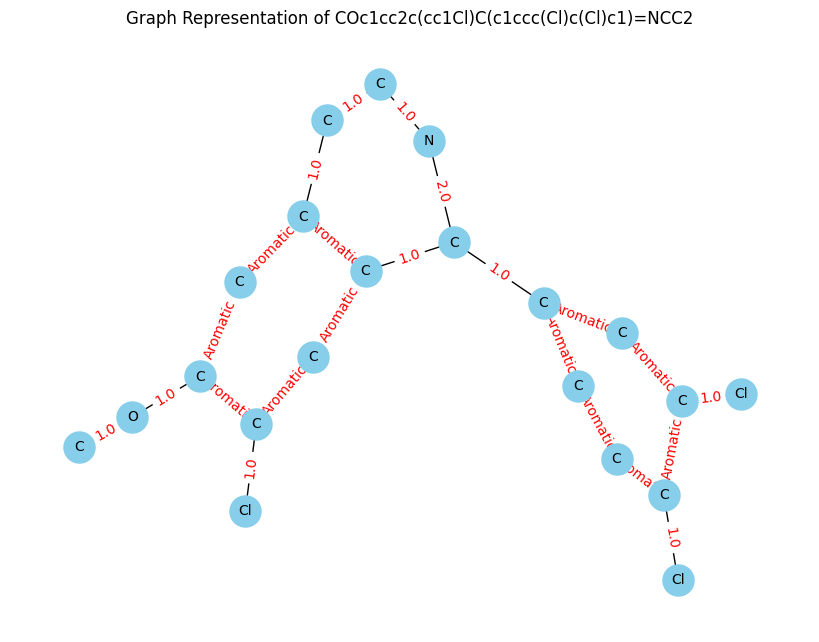

In [ ]:
compound_smiles = kiba_data['Drug'].iloc[0]
graph_data = convert_compound_to_graph(compound_smiles)
m = Chem.MolFromSmiles(compound_smiles)
img = Draw.MolToImage(m)

if graph_data:
    visualize_graph_with_bonds(graph_data, compound_smiles)
else:
    print("Invalid SMILES string.")

In [12]:
def visualize_molecule_graph(graph_data):
    """
    Visualize the molecular graph using NetworkX and Matplotlib.

    :param graph_data: PyTorch Geometric Data object.
    """
    # Create a NetworkX graph
    G = nx.Graph()

    # Add nodes with their features
    for i, atom_feature in enumerate(graph_data.x):
        label = f"Atom {int(atom_feature[0])}\nCharge: {int(atom_feature[2])}"
        G.add_node(i, label=label)

    # Add edges with bond types as labels
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        bond_type = graph_data.edge_attr[i].item()
        G.add_edge(src.item(), dst.item(), label=f"Bond: {bond_type}")

    # Draw the graph
    pos = nx.spring_layout(G, k=0.5, iterations=50) # Use spring layout for better visualization
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color="skyblue", node_size=800, font_size=10, font_weight="bold",labels=nx.get_node_attributes(G, 'label'))


    # Add edge labels
    edge_labels = {(u, v): G[u][v]['label'] for u, v in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size =8)

    plt.title("Molecular Graph Representation with Node and Edge Embeddings")
    plt.show()

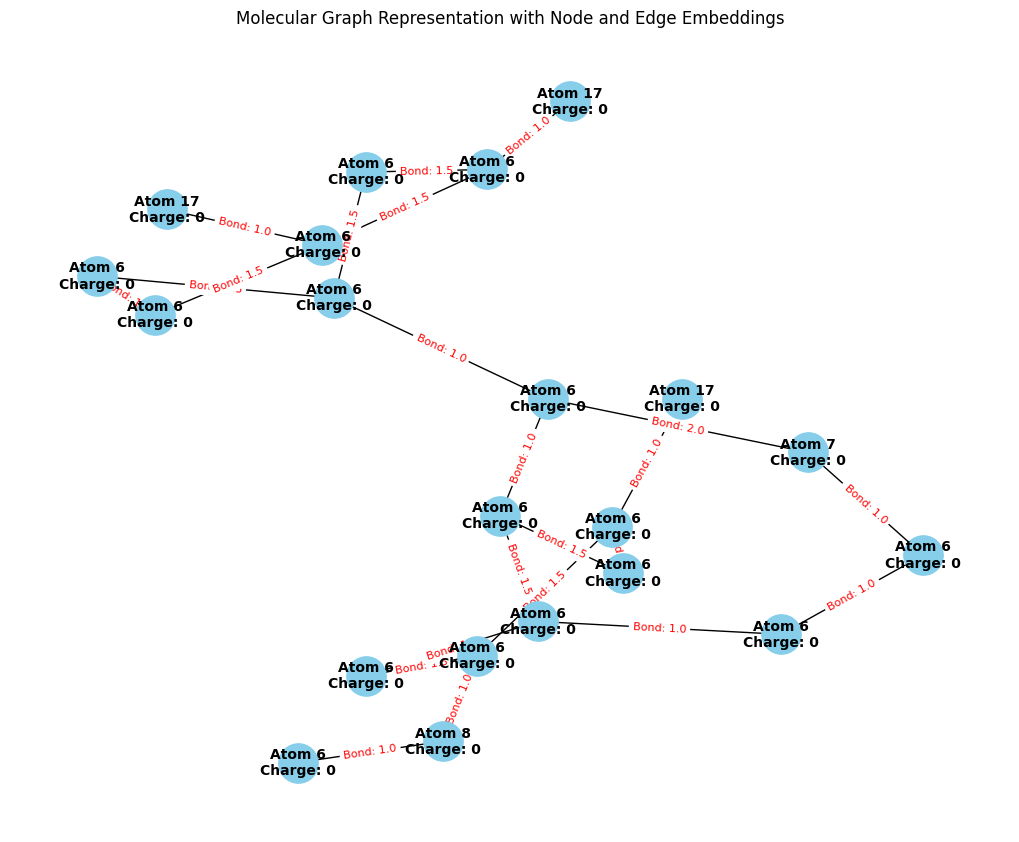

In [ ]:
visualize_molecule_graph(graph_data)

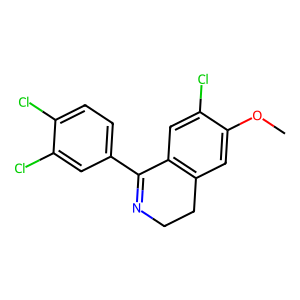

In [ ]:
img

In [13]:
# Initialize ProtBERT model and tokenizer
model_name = 'Rostlab/prot_bert_bfd'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=False)
protbert_model = BertModel.from_pretrained(model_name)

def sequence_to_protbert_embedding(sequence, tokenizer, model, device):
    # Move model to the right device
    model = model.to(device)
    
    # Prepare input tokens and move them to the same device as model
    inputs = tokenizer(sequence, return_tensors='pt', truncation=True, padding=True)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state.mean(dim=1)  # Mean pooling

    # Return the embedding directly without needing to move it in the calling function
    return embedding.squeeze(0)


In [14]:

# Create directories for saving tensors
os.makedirs('graph_tensors', exist_ok=True)
os.makedirs('protein_embeddings', exist_ok=True)

In [15]:
protbert_model = protbert_model.to(device)

In [62]:
tqdm.pandas()

# Apply smiles_to_pyg_graph in parallel using swifter
print("Generating graphs from SMILES strings...")
kiba_data['graph'] = kiba_data['Drug'].swifter.apply(convert_compound_to_graph)



Generating graphs from SMILES strings...


Pandas Apply:   0%|          | 0/117657 [00:00<?, ?it/s]

In [24]:
# Apply sequence_to_protbert_embedding in parallel using swifter
print("Generating protein embeddings from sequences...")
kiba_data['protein_embedding'] = kiba_data['Target'].swifter.apply(sequence_to_protbert_embedding)


Generating protein embeddings from sequences...


Pandas Apply:   0%|          | 0/117657 [00:00<?, ?it/s]

In [16]:
# Test SMILES to graph conversion
sample_smiles = kiba_data['Drug'].iloc[0]
print(convert_compound_to_graph(sample_smiles))

# # Test protein sequence to embedding conversion
# sample_sequence = kiba_data['Target'].iloc[0]
# print(sequence_to_protbert_embedding(sample_sequence))


Data(x=[21, 5], edge_index=[2, 46], edge_attr=[46, 1])


In [16]:
kiba_data.head()

,Drug_ID,Drug,Target_ID,Target,Y,graph,protein_embedding,molecular_features
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,11.1,"[(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...","[tensor(0.0306), tensor(0.0243), tensor(0.1363...","[tensor(340.6370), tensor(5.0489), tensor(21.5..."
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,11.1,"[(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...","[tensor(0.0306), tensor(0.0243), tensor(0.1363...","[tensor(340.6370), tensor(5.0489), tensor(21.5..."
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,11.1,"[(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...","[tensor(0.0306), tensor(0.0243), tensor(0.1363...","[tensor(340.6370), tensor(5.0489), tensor(21.5..."
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,11.1,"[(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...","[tensor(0.0306), tensor(0.0243), tensor(0.1363...","[tensor(340.6370), tensor(5.0489), tensor(21.5..."
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,11.1,"[(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...","[tensor(0.0306), tensor(0.0243), tensor(0.1363...","[tensor(340.6370), tensor(5.0489), tensor(21.5..."


In [17]:
kiba_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117657 entries, 0 to 117656
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Drug_ID             117657 non-null  object 
 1   Drug                117657 non-null  object 
 2   Target_ID           117657 non-null  object 
 3   Target              117657 non-null  object 
 4   Y                   117657 non-null  float64
 5   graph               117657 non-null  object 
 6   protein_embedding   117657 non-null  object 
 7   molecular_features  117657 non-null  object 
dtypes: float64(1), object(7)
memory usage: 7.2+ MB


In [18]:
kiba_data['graph'].head()

0    [(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...
1    [(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...
2    [(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...
3    [(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...
4    [(x, [tensor([6, 3, 0, 0, 4]), tensor([8, 0, 0...
Name: graph, dtype: object

In [19]:
kiba_data['protein_embedding'].head()

0    [tensor(0.0306), tensor(0.0243), tensor(0.1363...
1    [tensor(0.0306), tensor(0.0243), tensor(0.1363...
2    [tensor(0.0306), tensor(0.0243), tensor(0.1363...
3    [tensor(0.0306), tensor(0.0243), tensor(0.1363...
4    [tensor(0.0306), tensor(0.0243), tensor(0.1363...
Name: protein_embedding, dtype: object

In [20]:
kiba_data['molecular_features'].head()

0    [tensor(340.6370), tensor(5.0489), tensor(21.5...
1    [tensor(340.6370), tensor(5.0489), tensor(21.5...
2    [tensor(340.6370), tensor(5.0489), tensor(21.5...
3    [tensor(340.6370), tensor(5.0489), tensor(21.5...
4    [tensor(340.6370), tensor(5.0489), tensor(21.5...
Name: molecular_features, dtype: object

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing

In [17]:
from rdkit.Chem import Descriptors, rdMolDescriptors
import pickle

# Define the molecular feature extraction function
def extract_molecular_features(compound_smiles):
    mol = Chem.MolFromSmiles(compound_smiles)
    if mol is None:
        return torch.zeros(10)  # Handle invalid SMILES with zero-filled tensor

    return torch.tensor([
        Descriptors.MolWt(mol),               # Molecular weight
        Descriptors.MolLogP(mol),             # LogP
        Descriptors.TPSA(mol),                # Topological polar surface area
        Descriptors.NumHDonors(mol),          # Hydrogen bond donors
        Descriptors.NumHAcceptors(mol),       # Hydrogen bond acceptors
        Descriptors.NumRotatableBonds(mol),   # Rotatable bonds
        rdMolDescriptors.CalcNumRings(mol),        # Number of rings
        rdMolDescriptors.CalcNumAromaticRings(mol),# Aromatic rings
        Descriptors.FractionCSP3(mol),        # Carbon hybridization (sp3 fraction)
        rdMolDescriptors.CalcExactMolWt(mol)       # Exact molecular weight
    ], dtype=torch.float)

# # Extract molecular features and add them to the DataFrame
# tqdm.pandas(desc="Extracting Molecular Features")
# kiba_data['molecular_features'] = kiba_data['Drug'].progress_apply(extract_molecular_features)

# # Save the DataFrame as a pickle file
# with open('kiba_with_molecular_features.pkl', 'wb') as f:
#     pickle.dump(kiba_data, f)

# print("Data saved as 'kiba_with_molecular_features.pkl'")


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import MessagePassing
from rdkit import Chem
from tqdm import tqdm


In [53]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch_geometric.data import Data, Batch
from tqdm import tqdm

# Define hyperparameters and other constants
num_epochs = 10  # Number of training epochs
batch_size = 32  # Size of each batch
learning_rate = 0.1 # Learning rate for the optimizer
hidden_dim = 128  # Hidden dimension for the network layers
mol_features_dim = 10  # Number of molecular features
protein_dim = 1024  # Dimension of protein embeddings
num_layers = 12  # Number of Graph Transformer layers
num_heads = 8  # Number of attention heads
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Set device

# Initialize model, optimizer, and loss function
model = DTIModel(
    drug_in_dim=5,            # Input dimension of drug node features
    drug_hidden_dim=hidden_dim,  # Hidden dimension size
    protein_dim=protein_dim,  # Dimension of protein embeddings
    hidden_dim=hidden_dim,    # Common hidden dimension for attention
    num_layers=num_layers,    # Number of layers in the Graph Transformer
    num_heads=num_heads,      # Number of attention heads
    mol_features_dim=mol_features_dim  # Molecular feature dimension
).to(device)  # Ensure model is on the correct device

optimizer = Adam(model.parameters(), lr=learning_rate)  # Optimizer
criterion = nn.MSELoss()  # Mean Squared Error (MSE) Loss

# Calculate the number of batches per epoch
num_batches = len(train_data) // batch_size


In [54]:
from torch_geometric.data import Data, Batch

def get_batch(data, batch_size=32):
    for i in range(0, len(data), batch_size):
        batch = data.iloc[i:i + batch_size]
        graph_list = []
        mol_features_list, protein_embedding_list, target_list = [], [], []

        for _, row in batch.iterrows():
            graph = row['graph']  # Assuming this is already a PyG Data object
            mol_features = row['molecular_features']
            protein_embedding = row['protein_embedding'].clone().detach().float()
            target = torch.tensor(row['Y'], dtype=torch.float32).unsqueeze(0)

            graph_list.append(graph)  # Append the whole graph as a Data object
            mol_features_list.append(mol_features)
            protein_embedding_list.append(protein_embedding)
            target_list.append(target)

        yield (
            Batch.from_data_list(graph_list),  # Batch the list of Data objects
            torch.stack(mol_features_list),  # Molecular features as a tensor
            torch.stack(protein_embedding_list),  # Protein embeddings as a tensor
            torch.cat(target_list).view(-1,1)  # Targets as a tensor
        )


In [21]:
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

In [24]:
drug_new = 'COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2'
protein_seq_new = 'MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNSYACKHPEVQSILKISQPQEPELMNANPSPPPSPSQQINLGPSSNPHAKPSDFHFLKVIGKGSFGKVLLARHKAEEVFYAVKVLQKKAILKKKEEKHIMSERNVLLKNVKHPFLVGLHFSFQTADKLYFVLDYINGGELFYHLQRERCFLEPRARFYAAEIASALGYLHSLNIVYRDLKPENILLDSQGHIVLTDFGLCKENIEHNSTTSTFCGTPEYLAPEVLHKQPYDRTVDWWCLGAVLYEMLYGLPPFYSRNTAEMYDNILNKPLQLKPNITNSARHLLEGLLQKDRTKRLGAKDDFMEIKSHVFFSLINWDDLINKKITPPFNPNVSGPNDLRHFDPEFTEEPVPNSIGKSPDSVLVTASVKEAAEAFLGFSYAPPTDSFL'

drug_graph_n = convert_compound_to_graph(drug_new).to(device)
mol_feature_n = extract_molecular_features(drug_new).to(device)
protein_embedding_n = sequence_to_protbert_embedding(protein_seq_new, tokenizer, protbert_model, device)

# Ensure the dimensions are correct (add batch dimension if necessary)
mol_feature_n = mol_feature_n.unsqueeze(0)
protein_embedding_n = protein_embedding_n.unsqueeze(0)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [31]:
drug_graph_n

Data(x=[21, 5], edge_index=[2, 46], edge_attr=[46, 1])

In [32]:
mol_feature_n

tensor([[3.4064e+02, 5.0489e+00, 2.1590e+01, 0.0000e+00, 2.0000e+00, 2.0000e+00,
         3.0000e+00, 2.0000e+00, 1.8750e-01, 3.3900e+02]], device='cuda:0')

In [33]:
protein_embedding_n

tensor([[ 0.0306,  0.0243,  0.1363,  ..., -0.0868, -0.1145, -0.0130]],
       device='cuda:0')

In [67]:
print("Output layer weights:", model.fc.weight)
print("Output layer bias:", model.fc.bias)


Output layer weights: Parameter containing:
tensor([[-2.7581e-04,  2.8217e-04,  3.3629e-01,  2.9253e-04, -1.1694e-01,
         -2.8550e-04,  3.2959e-01, -2.9610e-01,  2.7895e-04, -2.9348e-04,
          2.8737e-04, -3.4701e-01, -2.6429e-01, -2.9362e-04,  2.9131e-04,
          2.9010e-04,  2.9022e-04, -1.7652e-01,  2.9272e-04,  3.2189e-01,
         -2.7574e-04, -4.6209e-01, -3.3673e-01, -4.5436e-01, -2.8628e-04,
          3.2233e-01,  2.9153e-04,  2.8131e-04, -2.8402e-04,  2.8909e-04,
         -3.0845e-01,  2.8206e-04, -3.9106e-01,  3.5562e-01, -2.9036e-04,
          2.8501e-04, -2.7815e-04,  3.3633e-01, -3.1072e-01, -2.9016e-04,
          2.9276e-04,  2.5115e-01,  2.8018e-04,  2.8912e-04, -2.9317e-04,
          2.9300e-04,  2.8366e-04, -2.2834e-01, -3.0737e-01, -2.9257e-04,
         -2.8526e-04,  1.3822e-01,  2.7347e-04,  3.3511e-01, -2.9045e-04,
         -3.6283e-01, -2.8349e-04, -3.6824e-01, -3.6955e-01,  3.5476e-01,
         -3.7184e-01, -1.3272e-01,  4.7050e-01, -2.8987e-04,  2.9085

In [47]:
# Print the basic model summary
print("Model Summary:")


# Print detailed parameter information
print("\nDetailed Parameter Information:")
print("="*130)
print(f"{'Layer':<60} {'Size':<50} {'Requires Grad'}")
print("-"*130)

for name, param in model.named_parameters():
    print(f"{name:<60} {str(param.size()):<50} {param.requires_grad}")
print("="*130)


Model Summary:

Detailed Parameter Information:
Layer                                                        Size                                               Requires Grad
----------------------------------------------------------------------------------------------------------------------------------
graph_transformer.layers.0.query.weight                      torch.Size([128, 5])                               True
graph_transformer.layers.0.query.bias                        torch.Size([128])                                  True
graph_transformer.layers.0.key.weight                        torch.Size([128, 5])                               True
graph_transformer.layers.0.key.bias                          torch.Size([128])                                  True
graph_transformer.layers.0.value.weight                      torch.Size([128, 5])                               True
graph_transformer.layers.0.value.bias                        torch.Size([128])                                

In [23]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch.optim import Adam
from torch_geometric.data import Data, Batch
from tqdm import tqdm


class DynamicGraphTransformerLayer(MessagePassing):
    def __init__(self, in_dim, out_dim, num_heads=8, mol_features_dim=1, dropout=0.1):
        super(DynamicGraphTransformerLayer, self).__init__(aggr='add')
        self.num_heads = num_heads
        self.out_dim = out_dim // num_heads

        # Define Q, K, V transformations for multi-head attention
        self.query = nn.Linear(in_dim, out_dim)
        self.key = nn.Linear(in_dim, out_dim)
        self.value = nn.Linear(in_dim, out_dim)

        # Edge MLP will be initialized dynamically in forward pass
        self.edge_mlp = None

        # Linear projection for aligning edge features during message passing
        self.edge_projection = nn.Linear(self.out_dim, self.out_dim)

        # Linear transformation for the final output
        self.fc = nn.Linear(out_dim, out_dim)

        # Dropout and Feedforward Network
        self.dropout = nn.Dropout(dropout)
        self.feedforward = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim)
        )

    def forward(self, x, edge_index, edge_attr, mol_features):
        x = x.float()
        
        Q = self.query(x).view(-1, self.num_heads, self.out_dim)
        K = self.key(x).view(-1, self.num_heads, self.out_dim)
        V = self.value(x).view(-1, self.num_heads, self.out_dim)

        Q = Q.permute(1, 0, 2)  # (num_heads, num_nodes, head_dim)
        K = K.permute(1, 0, 2)  # (num_heads, num_nodes, head_dim)
        V = V.permute(1, 0, 2)  # (num_heads, num_nodes, head_dim)

        attention_scores = torch.einsum('hij,hik->hjk', Q, K) / (self.out_dim ** 0.5)
        attention_weights = torch.softmax(attention_scores, dim=-1)
        out = torch.einsum('hjk,hik->hij', attention_weights, V)

        # Compute dynamic edge features and aggregate messages
        edge_attr = self.compute_dynamic_edge_features(x, edge_index, mol_features)
        out = self.propagate(edge_index, x=out, edge_attr=edge_attr)

        out = out.permute(1, 0, 2).reshape(x.size(0), -1)
        return self.fc(out)

    def compute_dynamic_edge_features(self, x, edge_index, mol_features):
        src, dst = edge_index  # Extract source and destination nodes
        num_edges = src.size(0)  # Number of edges

        # Flatten molecular features and repeat to match number of edges
        mol_features = mol_features.view(mol_features.size(0), -1)
        repeats = (num_edges + mol_features.size(0) - 1) // mol_features.size(0)
        expanded_mol_features = mol_features.repeat(repeats, 1)[:num_edges]

        # Concatenate source, destination node features, and molecular features
        edge_features = torch.cat([x[src], x[dst], expanded_mol_features], dim=-1)

        # Dynamically initialize edge_mlp based on edge_features shape
        if self.edge_mlp is None or self.edge_mlp[0].in_features != edge_features.shape[-1]:
            self.edge_mlp = nn.Sequential(
                nn.Linear(edge_features.shape[-1], 128),
                nn.ReLU(),
                nn.Linear(128, self.out_dim)
            ).to(edge_features.device)

        return self.edge_mlp(edge_features)


    def message(self, x_j, edge_attr):
        # Align edge attributes with node features via linear projection
        projected_edge_attr = self.edge_projection(edge_attr)  # Shape: [num_edges, out_dim]

        # Expand edge attributes to match the batch size if needed
        expanded_edge_attr = projected_edge_attr.unsqueeze(0).expand(x_j.size(0), -1, -1)

        return x_j + expanded_edge_attr
    

class GraphTransformerNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers, num_heads=8, mol_features_dim=10, dropout=0.1):
        super(GraphTransformerNet, self).__init__()
        self.layers = nn.ModuleList([
            DynamicGraphTransformerLayer(
                in_dim if i == 0 else hidden_dim, hidden_dim, num_heads, mol_features_dim, dropout
            ) for i in range(num_layers)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, batch, mol_features):
        x, edge_index, edge_attr = batch.x, batch.edge_index, batch.edge_attr

        for layer in self.layers:
            x = layer(x, edge_index, edge_attr, mol_features)
        return self.pool(x.T).squeeze(-1)

class DrugProteinAttention(nn.Module):
    def __init__(self, drug_dim, protein_dim, hidden_dim, dropout=0.1):
        super(DrugProteinAttention, self).__init__()
        self.query = nn.Linear(drug_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.pool = nn.AdaptiveAvgPool1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, drug_embed, protein_embed):
        drug_embed = drug_embed.view(1, -1)
        protein_embed = protein_embed.view(1, 1, -1)
        protein_embed = self.pool(protein_embed).view(1, -1)

        Q = self.query(drug_embed)
        K = self.key(protein_embed)
        V = self.value(protein_embed)

        attention_scores = torch.softmax(torch.matmul(Q, K.T) / (K.size(-1) ** 0.5), dim=-1)
        interaction = torch.matmul(attention_scores, V)

        return self.dropout(interaction)

class DTIModel(nn.Module):
    def __init__(self, drug_in_dim, drug_hidden_dim, protein_dim, hidden_dim, num_layers, num_heads, mol_features_dim, dropout=0.1):
        super(DTIModel, self).__init__()
        self.graph_transformer = GraphTransformerNet(
            in_dim=drug_in_dim,
            hidden_dim=drug_hidden_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            mol_features_dim=mol_features_dim,
            dropout=dropout
        )
        self.attention = DrugProteinAttention(
            drug_dim=drug_hidden_dim,
            protein_dim=protein_dim,
            hidden_dim=hidden_dim,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, batch, mol_features, protein_embedding):
        mol_features = mol_features.float()
        protein_embedding = protein_embedding.float()

        drug_embed = self.graph_transformer(batch, mol_features)

        if protein_embedding.dim() == 1:
            protein_embedding = protein_embedding.unsqueeze(1)

        interaction = self.attention(drug_embed, protein_embedding)
        output = self.fc(interaction)

        return output

# Training Code without batching
num_epochs = 10
learning_rate = 0.0001
hidden_dim = 128
mol_features_dim = 10
protein_dim = 1024
num_layers = 12
num_heads = 8
dropout = 0.1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DTIModel(
    drug_in_dim=5,
    drug_hidden_dim=hidden_dim,
    protein_dim=protein_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    mol_features_dim=mol_features_dim,
    dropout=dropout
).to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [26]:
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, auc, matthews_corrcoef, mean_squared_error, r2_score

# Initialize lists to store predictions and targets for metric calculations
all_outputs, all_targets = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    # Using tqdm to track progress within the epoch
    with tqdm(train_data.iterrows(), total=len(train_data), desc=f'Epoch {epoch + 1}/{num_epochs}') as progress_bar:
        for _, row in progress_bar:
            graph = row['graph'].to(device)
            mol_features = row['molecular_features'].to(device).float()
            protein_embedding = row['protein_embedding'].to(device).float()
            target = torch.tensor(row['Y'], dtype=torch.float32).unsqueeze(0).to(device)

            optimizer.zero_grad()
            output = model(graph, mol_features, protein_embedding)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

            # Store outputs and targets for metric calculation
            all_outputs.append(output.item())
            all_targets.append(target.item())

            # Update tqdm with the current loss
            progress_bar.set_postfix(loss=loss.item())

    # Calculate metrics at the end of each epoch
    avg_train_loss = total_train_loss / len(train_data)

    # Calculate MSE and R2
    mse = mean_squared_error(all_targets, all_outputs)
    # r2 = r2_score(all_targets, all_outputs)

    # # Calculate AUPR
    # precision, recall, _ = precision_recall_curve(all_targets, all_outputs)
    # aupr = auc(recall, precision)

    # # Calculate MCC
    # outputs_binary = [1 if o > 0.5 else 0 for o in all_outputs]  # Binarize predictions if needed
    # mcc = matthews_corrcoef(all_targets, outputs_binary)

    print(f"Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | MSE: {mse:.4f} ")

    # Clear outputs for the next epoch
    all_outputs, all_targets = [], []


Epoch 1/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/10: 100%|██████████| 94125/94125 [2:04:06<00:00, 12.64it/s, loss=0.000101]  


Epoch 1/10 | Train Loss: 9.4285 | MSE: 9.4285 


Epoch 2/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2/10: 100%|██████████| 94125/94125 [1:52:31<00:00, 13.94it/s, loss=0.00648]   


Epoch 2/10 | Train Loss: 8.0941 | MSE: 8.0941 


Epoch 3/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3/10: 100%|██████████| 94125/94125 [1:53:30<00:00, 13.82it/s, loss=0.0657]    


Epoch 3/10 | Train Loss: 7.2387 | MSE: 7.2387 


Epoch 4/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4/10: 100%|██████████| 94125/94125 [1:53:44<00:00, 13.79it/s, loss=1.85]      


Epoch 4/10 | Train Loss: 7.4707 | MSE: 7.4707 


Epoch 5/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5/10: 100%|██████████| 94125/94125 [1:57:44<00:00, 13.32it/s, loss=6.31e-5]   


Epoch 5/10 | Train Loss: 7.5683 | MSE: 7.5683 


Epoch 6/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6/10: 100%|██████████| 94125/94125 [1:58:36<00:00, 13.23it/s, loss=0.155]     


Epoch 6/10 | Train Loss: 6.5823 | MSE: 6.5823 


Epoch 7/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7/10: 100%|██████████| 94125/94125 [2:02:54<00:00, 12.76it/s, loss=0.00191]   


Epoch 7/10 | Train Loss: 8.4071 | MSE: 8.4071 


Epoch 8/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8/10: 100%|██████████| 94125/94125 [1:58:57<00:00, 13.19it/s, loss=0.0121]    


Epoch 8/10 | Train Loss: 7.9304 | MSE: 7.9304 


Epoch 9/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9/10: 100%|██████████| 94125/94125 [2:05:09<00:00, 12.53it/s, loss=1.2]       


Epoch 9/10 | Train Loss: 6.6752 | MSE: 6.6752 


Epoch 10/10:   0%|          | 0/94125 [00:00<?, ?it/s]d:\anaconda\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10/10: 100%|██████████| 94125/94125 [2:07:40<00:00, 12.29it/s, loss=1.5]       


Epoch 10/10 | Train Loss: 7.4087 | MSE: 7.4087 


In [44]:
# Correct way to save the model state and the optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model_checkpoint_final.pth')

# Print a confirmation
print("Model saved successfully!")

Model saved successfully!


In [25]:
# Load the checkpoint
checkpoint = torch.load('model_checkpoint_final.pth')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Ensure the model is in evaluation mode if only making predictions
model.eval()

print("Model and optimizer states have been loaded successfully.")

Model and optimizer states have been loaded successfully.


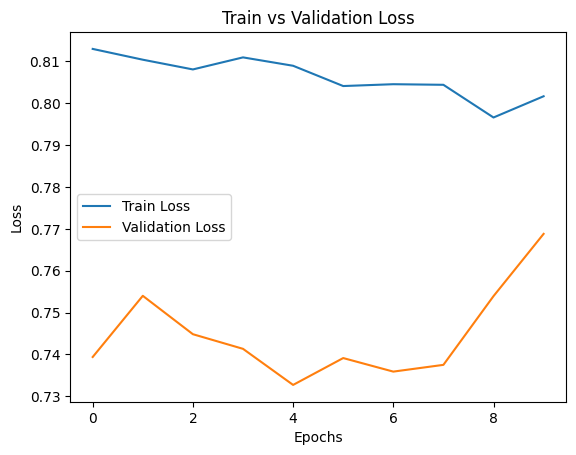

In [46]:
# Optionally plot train and val losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch

# Initialize variables to accumulate results
all_outputs = []
all_targets = []

model.eval()
with torch.no_grad():
    for _, row in test_data.iterrows():
        graph = row['graph'].to(device)
        mol_features = row['molecular_features'].to(device).float()
        protein_embedding = row['protein_embedding'].to(device).float()
        target = torch.tensor(row['Y'], dtype=torch.float32).unsqueeze(0).to(device)

        output = model(graph, mol_features, protein_embedding).view(-1)

        all_outputs.append(output.item())
        all_targets.append(target.item())

# Convert to tensors for easier calculations
all_outputs = torch.tensor(all_outputs)
all_targets = torch.tensor(all_targets)

# Calculate regression metrics
mse = mean_squared_error(all_targets, all_outputs)
r2 = r2_score(all_targets, all_outputs)
mae = mean_absolute_error(all_targets, all_outputs)


# Print results
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")


MSE: 0.3751
MAE: 0.5745


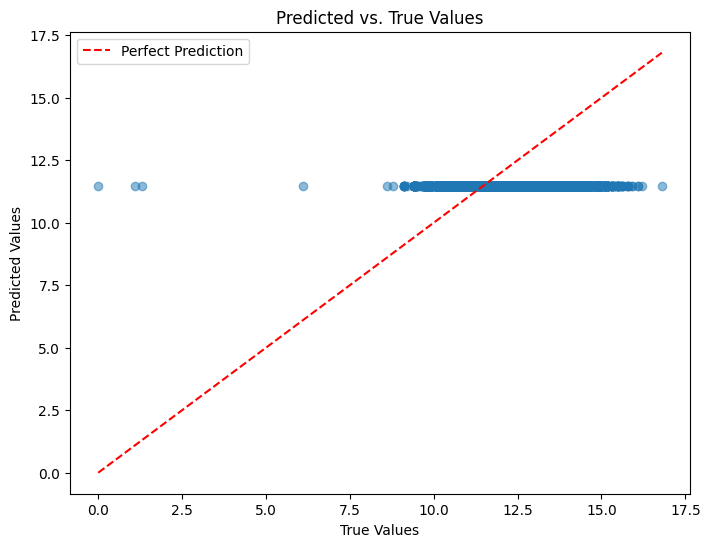

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(all_targets, all_outputs, alpha=0.5)
plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], 'r--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.legend()
plt.show()


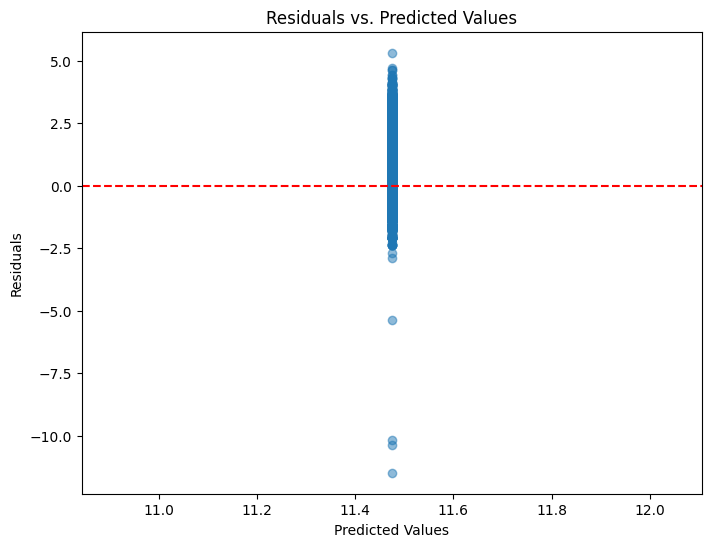

In [31]:
residuals = all_targets - all_outputs
plt.figure(figsize=(8, 6))
plt.scatter(all_outputs, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()


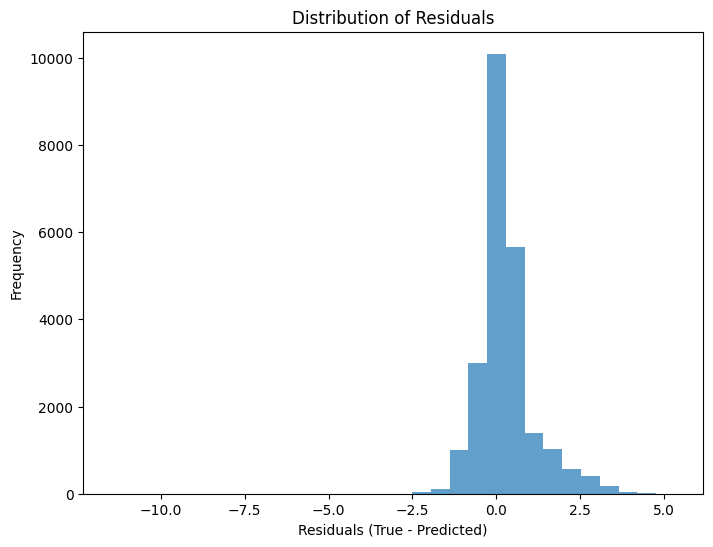

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals (True - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch

# Select a single test data point
test_sample = test_data.iloc[0]  # Replace with the index of the desired sample
drug_smiles = test_sample['Drug']  # Assuming 'drug_smiles' is a column in test_data
protein_sequence = test_sample['Target']  # Assuming 'protein_sequence' is a column in test_data
target_value = test_sample['Y']  # Assuming 'Y' is the target value column

# Prepare the input data for the model
graph = test_sample['graph'].to(device)
mol_features = torch.tensor(test_sample['molecular_features']).to(device).float()
protein_embedding = torch.tensor(test_sample['protein_embedding']).to(device).float()
target_value_tensor = torch.tensor(target_value).to(device).float()

# Switch the model to evaluation mode
model.eval()
with torch.no_grad():
    # Forward pass for prediction
    predicted_value = model(graph, mol_features, protein_embedding).item()

# Print the inputs and the prediction
print(f"Drug SMILES: {drug_smiles}")
print(f"Protein Sequence: {protein_sequence}")
print(f"Target Value (True): {target_value}")
print(f"Predicted Value: {predicted_value:.4f}")


Drug SMILES: NC(=O)c1cc(-c2ccnc(N)n2)[nH]c1-c1ccc(Cl)cc1Cl
Protein Sequence: MSSWIRWHGPAMARLWGFCWLVVGFWRAAFACPTSCKCSASRIWCSDPSPGIVAFPRLEPNSVDPENITEIFIANQKRLEIINEDDVEAYVGLRNLTIVDSGLKFVAHKAFLKNSNLQHINFTRNKLTSLSRKHFRHLDLSELILVGNPFTCSCDIMWIKTLQEAKSSPDTQDLYCLNESSKNIPLANLQIPNCGLPSANLAAPNLTVEEGKSITLSCSVAGDPVPNMYWDVGNLVSKHMNETSHTQGSLRITNISSDDSGKQISCVAENLVGEDQDSVNLTVHFAPTITFLESPTSDHHWCIPFTVKGNPKPALQWFYNGAILNESKYICTKIHVTNHTEYHGCLQLDNPTHMNNGDYTLIAKNEYGKDEKQISAHFMGWPGIDDGANPNYPDVIYEDYGTAANDIGDTTNRSNEIPSTDVTDKTGREHLSVYAVVVIASVVGFCLLVMLFLLKLARHSKFGMKGPASVISNDDDSASPLHHISNGSNTPSSSEGGPDAVIIGMTKIPVIENPQYFGITNSQLKPDTFVQHIKRHNIVLKRELGEGAFGKVFLAECYNLCPEQDKILVAVKTLKDASDNARKDFHREAELLTNLQHEHIVKFYGVCVEGDPLIMVFEYMKHGDLNKFLRAHGPDAVLMAEGNPPTELTQSQMLHIAQQIAAGMVYLASQHFVHRDLATRNCLVGENLLVKIGDFGMSRDVYSTDYYRVGGHTMLPIRWMPPESIMYRKFTTESDVWSLGVVLWEIFTYGKQPWYQLSNNEVIECITQGRVLQRPRTCPQEVYELMLGCWQREPHMRKNIKGIHTLLQNLAKASPVYLDILG
Target Value (True): 11.500000186
Predicted Value: 11.4997


C:\Users\ashwi\AppData\Local\Temp\ipykernel_19580\2955364808.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mol_features = torch.tensor(test_sample['molecular_features']).to(device).float()
C:\Users\ashwi\AppData\Local\Temp\ipykernel_19580\2955364808.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  protein_embedding = torch.tensor(test_sample['protein_embedding']).to(device).float()


In [29]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDistGeom

def smiles_to_pdb(smiles, output_filename):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string")
    
    # Add hydrogens
    mol = Chem.AddHs(mol)
    
    # Generate 3D coordinates
    AllChem.EmbedMolecule(mol, AllChem.ETKDG())
    AllChem.MMFFOptimizeMolecule(mol)
    
    # Write to PDB file
    Chem.MolToPDBFile(mol, output_filename)
    print(f"3D structure saved to {output_filename}")

# # Example usage
# smiles = "C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N"  # Example: Ibuprofen
output_file = "test_sample1.pdb"
smiles_to_pdb(drug_smiles, output_file)


3D structure saved to test_sample1.pdb


In [30]:
from pymol import cmd

# Load protein structure
cmd.load("AF-A0A2R9BM51-F1-model_v4.pdb", "protein")

# Remove water and ions
cmd.remove("resn HOH")
cmd.remove("resn NA+ or resn CL-")

# Add hydrogens
cmd.h_add("protein")

# Save cleaned structure
cmd.save("receptor_cleaned.pdb")
cmd.quit()


SystemError: <built-in function _start> returned a result with an exception set

: 